# Import Packages

In [116]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# Calibrate Camera

To calibrate camera we use chessboard images provided in the project folder.
```cv2.findChessboardCorners``` finds chessboard corners which are used to find distortion coeffecients and camera matrix

In [117]:
# Let's import all calibration images and produce objectpoints and image points
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

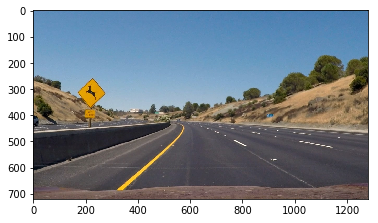

In [118]:
# Let's show one chessboard before calibration
test_img = mpimg.imread('test_images/test2.jpg')
plt.imshow(test_img)

In [119]:
# Let's calibrate camera using objectpoints and imagepoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img.shape[1::-1], None, None)

# Undistort image

We use camera matrix and distortion coeffecients to undistort an image. This is the first step of our pipeline.

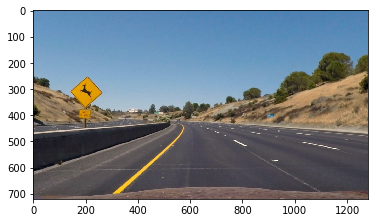

In [120]:
# Let's undistort the test image
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

undistorted_test_img = undistort(test_img)
plt.imshow(undistorted_test_img)

# Threshold an image

Next step of our pipeline is to convert undistorted RGB road image to binary image with lane lines being highlighted relative to its background.

To detect yellow line we use B channel of LAB color space. We select all pixels which are above 97th percentile of B channel values. Such a 97th percentile threshold is calculated in the lower half of the image to eliminate sky and increase influence of the road on percentile calculation.

To detect white line we use Y channel of YCrCb color space. The lower threshold is 97th percentile, upper threshold is max value of Y channel.

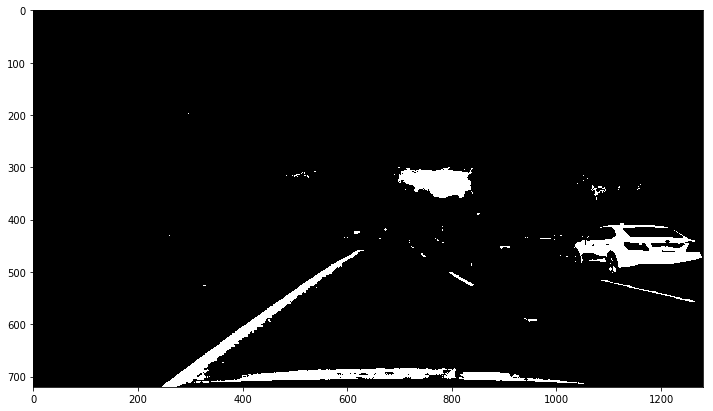

In [121]:
def threshold_image(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    margin = 70
    yellow_low = 15
    yellow_high = 35
    value_threshold = np.percentile(hls[:,:,1], 80)

    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    binary_mask = np.zeros_like(V)
    binary_mask[np.where(hls[:,:,1] > 255 - margin)] = 255
    binary_mask[np.where((hsv[:,:,0] >= yellow_low) & (hsv[:,:,0] <= yellow_high) & (hsv[:,:,2] >= value_threshold) & (hsv[:,:,1] >= 50))] = 255
    
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    ycb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]

    Y = ycb[:,:,0]
    Cr = ycb[:,:,1]
    Cb = ycb[:,:,2]

    height = Y.shape[0]
    B_threshold = np.percentile(B[(int)(height/2):height,:], 97)
    yellow_mask = np.zeros_like(B)
    yellow_mask[B>=B_threshold] = 1

    Y_threshold = np.percentile(Y[(int)(height/2):height,:], 97)
    white_mask = np.zeros_like(Y)
    white_mask[Y>=Y_threshold] = 1
    
    return yellow_mask | white_mask
    

test_img = mpimg.imread('debug/challenge_debug_18.jpg')
#test_img = mpimg.imread('test_images/test6.jpg')
test_img = undistort(test_img)

plt.figure(figsize=(12,12))
plt.imshow(threshold_image(test_img), cmap='gray')

# Perspective Transform

At this step we are finding direct and inverse perspective transform using source and destination points on some test image. Source points are four points on lane lines where two top points and two bottom points have same Y coordinate.
Destination points create rectangle.

Such transform allows to view road image from bird view which is convenient to estimate lane line polynomials.

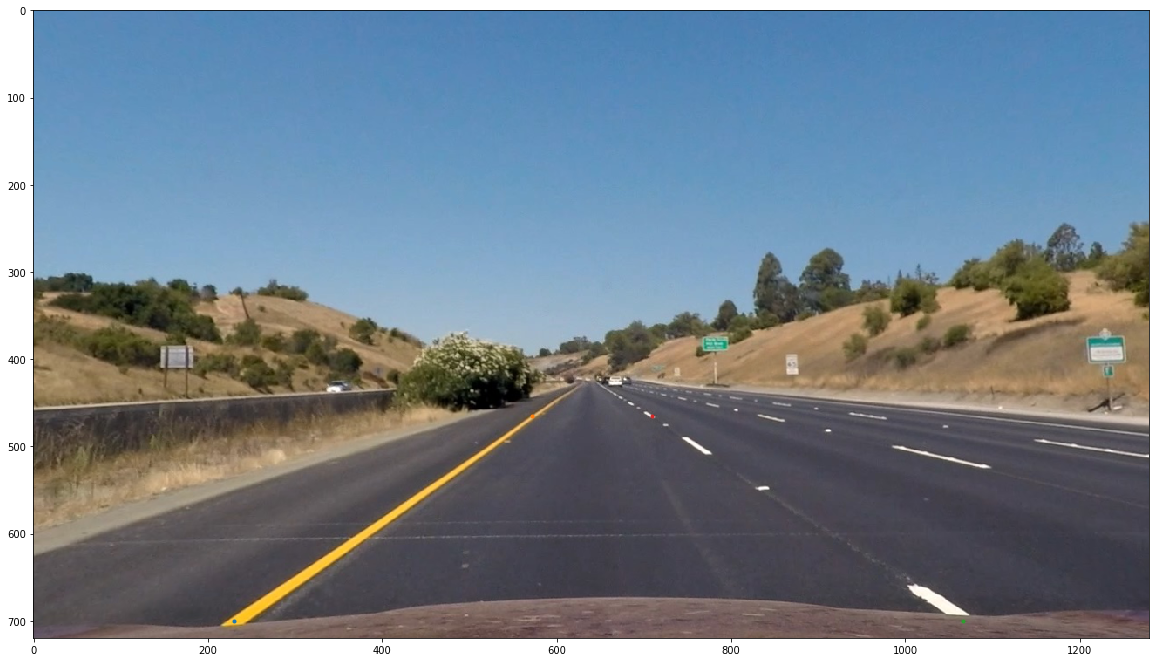

In [122]:
img = mpimg.imread('test_images/straight_lines1_undist.jpg')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.plot(230, 700, '.')
plt.plot(572, 465, '.')
plt.plot(1066, 700, '.')
plt.plot(709, 465, '.')

width = img.shape[1]
height = img.shape[0]
img_size = (width, height)

src = np.float32([[230, 700], [502, 514], [783, 514], [1066, 700]])
left_margin = 200
bottom_margin = 0
top_margin = 500
dst = np.float32([[left_margin, height-bottom_margin], [left_margin, top_margin], [width-left_margin, top_margin], [width-left_margin, height-bottom_margin]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


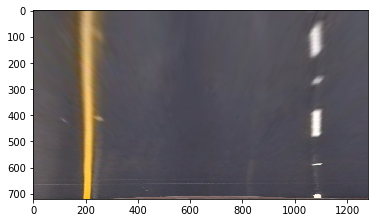

In [123]:
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

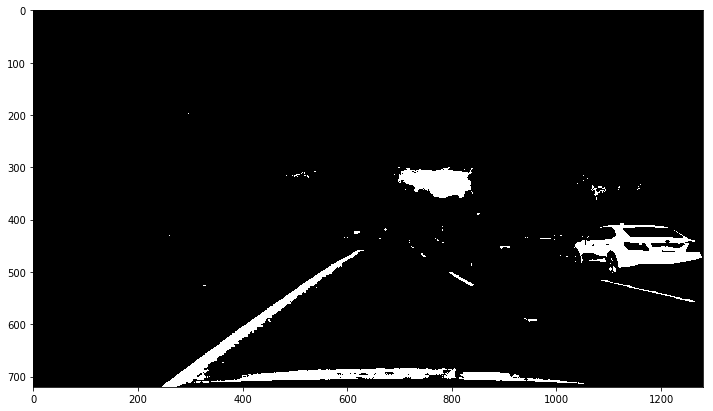

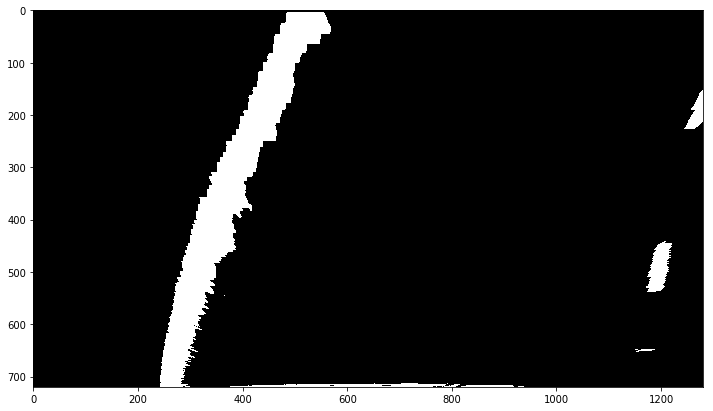

In [124]:
#img = mpimg.imread('test_images/test6.jpg')
img = mpimg.imread('debug/challenge_debug_18.jpg')
img = undistort(img)
img = threshold_image(img)
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='gray')

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(12,12))
plt.imshow(warped, cmap='gray')

Preprocess function converts raw rgb road image to undistorted thresholded warped binary image. It will be used in the pipeline.

In [125]:
def preprocess(img):
    undist = undistort(img)
    binary = threshold_image(undist)
    warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    warped = np.uint8(warped*255)
    return warped, undist

# Extract lane pixels

In [126]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #y values for detected line pixels
        self.ally = None  

Here we define a function which takes warped binary image and outputs x, y coordinates of activated pixels which can be used to fit polynomials which estimate lane line.
Majority of below code was taken from the lecture exercise.

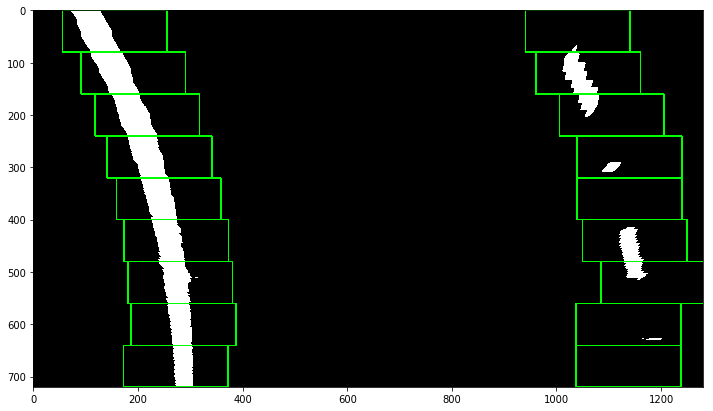

In [127]:
def getInitialCenters(img):
    height = img.shape[0]
    bottom_quarter = img[int(3*height/4):height,:]
    bottom_half = img[int(height/2):height,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)

def get_lane_pixels(img):
    leftx_current, rightx_current = getInitialCenters(img)
    
    out_img = np.dstack((img, img, img))
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_xs = []
    left_lane_ys = []
    right_lane_xs = []
    right_lane_ys = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        win_image_left = img[win_y_low:win_y_high,win_xleft_low:win_xleft_high]
        win_image_right = img[win_y_low:win_y_high,win_xright_low:win_xright_high]
        good_left_inds = win_image_left.nonzero()
        good_right_inds = win_image_right.nonzero()
        
        # Append these indices to the lists
        left_lane_ys.append(good_left_inds[0]+win_y_low)
        left_lane_xs.append(good_left_inds[1]+win_xleft_low)
        right_lane_ys.append(good_right_inds[0]+win_y_low)
        right_lane_xs.append(good_right_inds[1]+win_xright_low)
        
        if good_left_inds[1].shape[0] > minpix:
            leftx_current = int(np.mean(good_left_inds[1]))+win_xleft_low
            
        if good_right_inds[1].shape[0] > minpix:
            rightx_current = int(np.mean(good_right_inds[1]))+win_xright_low

    #Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_ys = np.concatenate(left_lane_ys)
    left_lane_xs = np.concatenate(left_lane_xs)
    right_lane_ys = np.concatenate(right_lane_ys)
    right_lane_xs = np.concatenate(right_lane_xs)

    return left_lane_xs, left_lane_ys, right_lane_xs, right_lane_ys, out_img
    
#img = mpimg.imread('debug/challenge_debug_18.jpg')
img = mpimg.imread('test_images/test2.jpg')
warped, undist = preprocess(img)
left_lane_xs, left_lane_ys, right_lane_xs, right_lane_ys, out_img = get_lane_pixels(warped)
plt.figure(figsize=(12, 12))
plt.imshow(out_img)

# Calculate polynomial

Here we define functions which fit 2-nd order polynomials for left and right lanes.

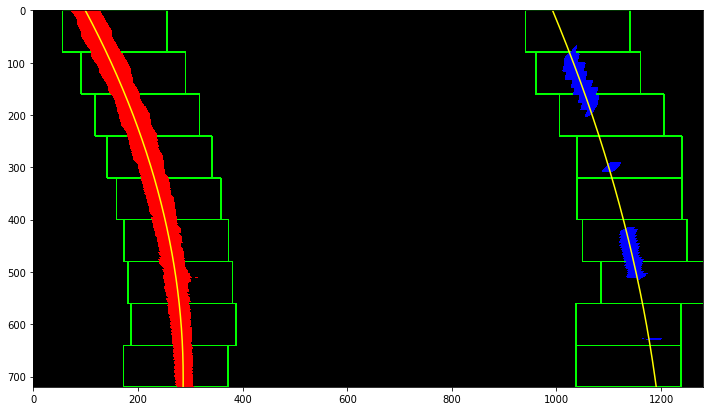

In [128]:
def fit_polynomial(leftx, lefty, rightx, righty, height):
    if leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0:
        return None, None, None, None, False
    
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, height-1, height )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fit, right_fit, True

def apply_polynomial(left_fit, right_fit, ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx
    
img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('debug/challenge_debug_18.jpg')
warped, undist = preprocess(img)
leftx, lefty, rightx, righty, out_img = get_lane_pixels(warped)
ploty, left_fit, right_fit, ret = fit_polynomial(leftx, lefty, rightx, righty, out_img.shape[0])
## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
left_fitx, right_fitx = apply_polynomial(left_fit, right_fit, ploty)
# Plots the left and right polynomials on the lane lines
plt.figure(figsize = (12, 12))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img, cmap='gray')

```search_around_poly``` is used to fit new polynomial using polynomial of left and right lane from previous video frame. This piece of code was taken from lecture exercise.

In [129]:
def search_around_poly(warped, left_fit, right_fit):
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = [index for index in range(len(nonzeroy)) if (left_fit[0]*(nonzeroy[index]**2)+left_fit[1]*nonzeroy[index]+left_fit[2]) >= nonzerox[index]-margin and (left_fit[0]*nonzeroy[index]**2+left_fit[1]*nonzeroy[index]+left_fit[2]) <= nonzerox[index]+margin ]
    right_lane_inds = [index for index in range(len(nonzeroy)) if (right_fit[0]*nonzeroy[index]**2+right_fit[1]*nonzeroy[index]+right_fit[2]) >= nonzerox[index]-margin and (right_fit[0]*nonzeroy[index]**2+right_fit[1]*nonzeroy[index]+right_fit[2]) <= nonzerox[index]+margin]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0:
        return None, None, None, False

    # Fit new polynomials
    height = warped.shape[0]
    ploty, left_fitx, right_fitx, ret = fit_polynomial(leftx, lefty, rightx, righty, height)
    
    return ploty, left_fitx, right_fitx, ret

```draw_lanes``` function draws lane lines using fitted polynomial coefficients and unwarps drawn image back to original coordinate system and overlays it over original road image creating an effect of green area drawn ahead of the car between two lane lines. This code has been taken from the lecture.

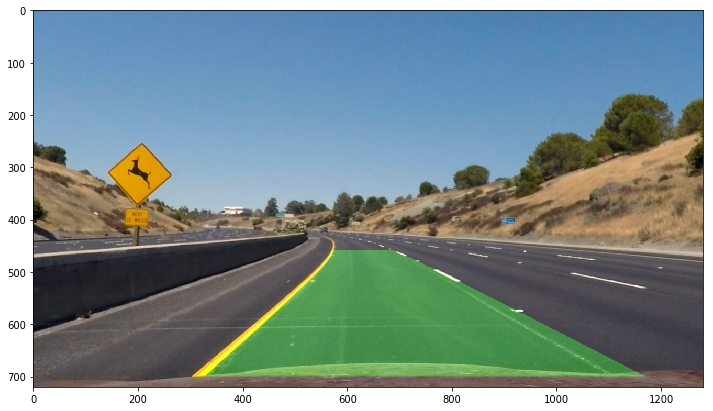

In [130]:
def draw_lanes(warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return np.array(result)
    
img = mpimg.imread('test_images/test2.jpg')
warped, undist = preprocess(img)
leftx, lefty, rightx, righty, out_img = get_lane_pixels(warped)
ploty, left_fit, right_fit, ret = fit_polynomial(leftx, lefty, rightx, righty, out_img.shape[0])
## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
left_fitx, right_fitx = apply_polynomial(left_fit, right_fit, ploty)
lanes_img = draw_lanes(warped, undist, left_fitx, right_fitx, ploty)
plt.figure(figsize=(12, 12))
plt.imshow(lanes_img)

This function applies polynomial coefficients to some given point y to obtain x=f(y).

In [139]:
def f(fit, y):
    x = fit[0]*(y**2)+fit[1]*y+fit[2]
    return x

This function calculates curvature of the lane line in meters using polynomial coefficients.

In [140]:
def calculate_curvature(left_fit, right_fit, height):
    # Taken from lecture
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/880 # meters per pixel in x dimension
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, height-1, num=height)# to cover same y-range as image
    leftx = np.array([f(left_fit, y) for y in ploty])
    rightx = np.array([f(right_fit, y) for y in ploty])
        
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    ploty = ploty*ym_per_pix
    leftx = leftx*xm_per_pix
    rightx = rightx*xm_per_pix
    
    left_fit_cr = np.polyfit(ploty, leftx, 2)
    right_fit_cr = np.polyfit(ploty, rightx, 2)
    y_eval = ym_per_pix*height-1
    
    left_curverad = (1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.absolute(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.absolute(2*right_fit_cr[0])
    
    #print("For polynomial coeffecients: ", left_fit, right_fit, "Left curvature: ", left_curverad, "Right curvature: ", right_curverad)
    return left_curverad, right_curverad

Same as above but returns curvature in pixel values.

In [141]:
def calculate_pixel_curvature(left_fit, right_fit, height):
    y_eval = height
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5/np.absolute(2*left_fit[0])
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5/np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

This function calculates offset of the car center from the lane center in meters. It uses warped binary image and polynomial coefficients of the left and right lane to perform such calculation.

In [142]:
def calculate_offset(warped_img, left_fit, right_fit):
    height = warped_img.shape[0]
    width = warped_img.shape[1]
    
    y_eval = height-1
    
    x_l = f(left_fit, y_eval)
    x_r = f(right_fit, y_eval)
    
    line_width = x_r-x_l
    
    center = int((x_l+x_r)/2)
    image_center = int(width/2)
    
    xm_per_pix = 3.7/line_width # meters per pixel in x dimension
    
    offset = (center - image_center)*xm_per_pix
    
    # if offset is positive, vehicle is on the left
    return offset

This function writes text on image. It is used for visualization of lane curvature and car center offset.

In [143]:
def write_text_on_image(img, text, level = 1):
    width = img.shape[1]
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (30,70)
    if level == 2:
        bottomLeftCornerOfText = (30, 120)
    fontScale              = 1.5
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(img, text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

Simpe sanity check of left and right line relative curvature. We discard estimated polynomials if curvature differs more than 5 times.

In [144]:
def sanity_check(left_fit, right_fit, height):
    left_curvature, right_curvature = calculate_pixel_curvature(left_fit, right_fit, height)
    
    # Polynomials with low curvature are probably incorrectly estimated
    if left_curvature <= 100 or right_curvature <= 100:
        return False
    
    ratio = left_curvature/right_curvature
    if ratio >5.0 or ratio < 1/5.0:
        return False
    
    return True

Weights used for weighted average of left and right lane polynomials.

In [145]:
weights = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

One of tha main functions of the pipeline, it gets warped and undistorted images and left and right line data from previous video frames.
It calculates new left and right polynomials using polynomials from previous frames, runs sanity check on new polynomial and if sanity check is passed adds new polynomial coefficients to historical data of 10 last polynomials.
After that it finds weighted average polynomial giving higher weight to recent estimations.

Such averaged polynomial coefficients are used to draw line lanes on undistorted image of the road.
Also such averaged polynomial coefficients are used to estimate lane curvatures and car center offset from the middle of the lane. Curvature and offset are drawn at the top of the image as text.

In [146]:
# This function gets new warped image, obtains polynomial fit data for this image and updates left and right lines
def update_lines(warped_img, undist_img, left_line, right_line):
    n = 10
    height = warped_img.shape[0]
    
    if left_line.best_fit == None or right_line.best_fit == None:
        leftx, lefty, rightx, righty, out_img = get_lane_pixels(warped_img)
        ploty, left_fit, right_fit, ret = fit_polynomial(leftx, lefty, rightx, righty, out_img.shape[0])
    else:
        ploty, left_fit, right_fit, ret = search_around_poly(warped_img, left_line.best_fit, right_line.best_fit)
    
    if ret == True and sanity_check(left_fit, right_fit, height) == False:
        ret = False

    if ret == False:
        left_fit = None
        right_fit = None
        
    if len(left_line.current_fit) >= n:
        left_line.current_fit.pop(0)
        
    if len(right_line.current_fit) >= n:
        right_line.current_fit.pop(0)
        
    left_line.current_fit.append(left_fit)
    right_line.current_fit.append(right_fit)
    
    if left_line.ally == None and ploty is not None:
        left_line.ally = ploty
        right_line.ally = ploty
    
    left_fit_to_average = [x for x in left_line.current_fit if x is not None]
    right_fit_to_average = [x for x in right_line.current_fit if x is not None]
    
    if len(left_fit_to_average) > 0 and len(right_fit_to_average) > 0:
        count = len(left_fit_to_average)
        average_left_fit = np.average(left_fit_to_average, axis=0, weights=weights[n-count:n:])
        average_right_fit = np.average(right_fit_to_average, axis=0, weights=weights[n-count:n:])

        left_fitx, right_fitx = apply_polynomial(average_left_fit, average_right_fit, left_line.ally)
    
        lanes_img = draw_lanes(warped_img, undist_img, left_fitx, right_fitx, left_line.ally)
        
        left_curvature, right_curvature = calculate_curvature(average_left_fit, average_right_fit, height)
        left_line.radius_of_curvature = left_curvature
        right_line.radius_of_curvature = right_curvature
        write_text_on_image(lanes_img, "Left curvature: {left_curvature:.0f} m, Right curvature: {right_curvature:.0f} m.".format(left_curvature=left_curvature, right_curvature=right_curvature))
            
        offset = calculate_offset(warped_img, average_left_fit, average_right_fit)
        write_text_on_image(lanes_img, "Vehicle is {offset:.2f}m {direction} of center.".format(offset=np.absolute(offset), direction='left' if offset > 0 else 'right'), 2)
            
        left_line.best_fit = average_left_fit
        right_line.best_fit = average_right_fit
        left_line.detected = True
        right_line.detected = True
        return lanes_img, left_line, right_line, True
    
    left_line.detected = False
    right_line.detected = False
    left_line.radius_of_curvature = None
    right_line.radius_of_curvature = None
    left_line.best_fit = None
    right_line.best_fit = None

    return undist_img, left_line, right_line, False
    

The function which is actually invoked for each video frame it simply preprocessed an image getting warped and undistorted image and calls ```update_lines``` to draw lane lines and curvature with car center offset on the image.

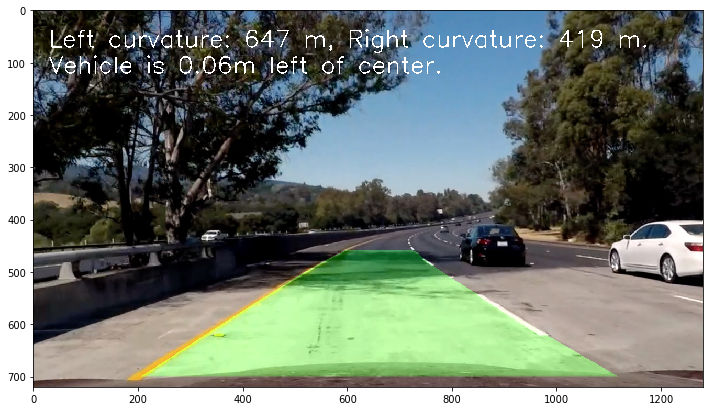

In [147]:
def process_image(img):
    global img_debug_counter
    global left_line
    global right_line
    warped, undist = preprocess(img)
    lanes_img, left_line, right_line, ret = update_lines(warped, undist, left_line, right_line)
        
    return lanes_img

left_line = Line()
right_line = Line()
img = mpimg.imread('test_images/test5.jpg')
processed = process_image(img)
plt.figure(figsize=(12, 12))
plt.imshow(processed)

Running the pipelin on project video, first crearing states for left and right line.

In [103]:
video_output = 'test_video_output/project_video.mp4'
left_line = Line()
right_line = Line()
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(process_image)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/project_video.mp4
[MoviePy] Writing video test_video_output/project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<07:34,  2.77it/s]


  0%|          | 2/1261 [00:00<07:43,  2.71it/s]


  0%|          | 3/1261 [00:01<07:40,  2.73it/s]


  0%|          | 4/1261 [00:01<07:44,  2.71it/s]


  0%|          | 5/1261 [00:01<08:14,  2.54it/s]


  0%|          | 6/1261 [00:02<08:39,  2.42it/s]


  1%|          | 7/1261 [00:02<08:46,  2.38it/s]


  1%|          | 8/1261 [00:03<08:26,  2.47it/s]


  1%|          | 9/1261 [00:03<08:11,  2.55it/s]


  1%|          | 10/1261 [00:03<08:21,  2.49it/s]


  1%|          | 11/1261 [00:04<08:39,  2.41it/s]


  1%|          | 12/1261 [00:05<09:39,  2.16it/s]


  1%|          | 13/1261 [00:05<09:52,  2.11it/s]


  1%|          | 14/1261 [00:05<09:48,  2.12it/s]


  1%|          | 15/1261 [00:06<09:35,  2.17it/s]


  1%|▏         | 16/1261 [00:06<09:42,  2.14it/s]


  1%|▏         | 17/1261 [00:07<09:34,  2.16it/s]


  1%|▏         | 18/1261 [00:07<09:20,  2.22it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [01:03<07:43,  2.43it/s]


 11%|█         | 135/1261 [01:03<08:04,  2.32it/s]


 11%|█         | 136/1261 [01:04<08:12,  2.28it/s]


 11%|█         | 137/1261 [01:04<08:23,  2.23it/s]


 11%|█         | 138/1261 [01:05<08:42,  2.15it/s]


 11%|█         | 139/1261 [01:05<09:10,  2.04it/s]


 11%|█         | 140/1261 [01:06<08:33,  2.18it/s]


 11%|█         | 141/1261 [01:06<08:04,  2.31it/s]


 11%|█▏        | 142/1261 [01:07<08:08,  2.29it/s]


 11%|█▏        | 143/1261 [01:07<07:46,  2.40it/s]


 11%|█▏        | 144/1261 [01:07<08:09,  2.28it/s]


 11%|█▏        | 145/1261 [01:08<08:27,  2.20it/s]


 12%|█▏        | 146/1261 [01:08<08:30,  2.19it/s]


 12%|█▏        | 147/1261 [01:09<08:04,  2.30it/s]


 12%|█▏        | 148/1261 [01:09<08:01,  2.31it/s]


 12%|█▏        | 149/1261 [01:10<07:55,  2.34it/s]


 12%|█▏        | 150/1261 [01:10<07:39,  2.42it/s]


 12%|█▏        | 151/1261 [01:10<07:45,  2.39it/s]


 12%|█▏        | 152/1261 [01:11<08:02,  2.30i

 21%|██        | 266/1261 [02:01<07:17,  2.27it/s]


 21%|██        | 267/1261 [02:02<07:22,  2.25it/s]


 21%|██▏       | 268/1261 [02:02<07:22,  2.24it/s]


 21%|██▏       | 269/1261 [02:03<07:21,  2.25it/s]


 21%|██▏       | 270/1261 [02:03<07:15,  2.28it/s]


 21%|██▏       | 271/1261 [02:04<07:07,  2.32it/s]


 22%|██▏       | 272/1261 [02:04<07:24,  2.22it/s]


 22%|██▏       | 273/1261 [02:05<07:45,  2.12it/s]


 22%|██▏       | 274/1261 [02:05<07:56,  2.07it/s]


 22%|██▏       | 275/1261 [02:06<08:06,  2.03it/s]


 22%|██▏       | 276/1261 [02:06<07:51,  2.09it/s]


 22%|██▏       | 277/1261 [02:06<07:31,  2.18it/s]


 22%|██▏       | 278/1261 [02:07<07:22,  2.22it/s]


 22%|██▏       | 279/1261 [02:07<07:14,  2.26it/s]


 22%|██▏       | 280/1261 [02:08<07:08,  2.29it/s]


 22%|██▏       | 281/1261 [02:08<06:57,  2.35it/s]


 22%|██▏       | 282/1261 [02:09<06:53,  2.37it/s]


 22%|██▏       | 283/1261 [02:09<07:06,  2.29it/s]


 23%|██▎       | 284/1261 [02:09<07:17,  2.24i

 32%|███▏      | 398/1261 [03:01<06:56,  2.07it/s]


 32%|███▏      | 399/1261 [03:02<06:57,  2.07it/s]


 32%|███▏      | 400/1261 [03:02<06:50,  2.10it/s]


 32%|███▏      | 401/1261 [03:03<06:38,  2.16it/s]


 32%|███▏      | 402/1261 [03:03<06:30,  2.20it/s]


 32%|███▏      | 403/1261 [03:04<06:29,  2.20it/s]


 32%|███▏      | 404/1261 [03:04<06:28,  2.21it/s]


 32%|███▏      | 405/1261 [03:05<06:26,  2.22it/s]


 32%|███▏      | 406/1261 [03:05<06:29,  2.20it/s]


 32%|███▏      | 407/1261 [03:06<06:30,  2.19it/s]


 32%|███▏      | 408/1261 [03:06<06:27,  2.20it/s]


 32%|███▏      | 409/1261 [03:06<06:36,  2.15it/s]


 33%|███▎      | 410/1261 [03:07<06:28,  2.19it/s]


 33%|███▎      | 411/1261 [03:07<06:15,  2.27it/s]


 33%|███▎      | 412/1261 [03:08<06:03,  2.34it/s]


 33%|███▎      | 413/1261 [03:08<06:04,  2.33it/s]


 33%|███▎      | 414/1261 [03:09<06:21,  2.22it/s]


 33%|███▎      | 415/1261 [03:09<06:23,  2.21it/s]


 33%|███▎      | 416/1261 [03:10<06:23,  2.20i

 42%|████▏     | 530/1261 [04:01<05:30,  2.21it/s]


 42%|████▏     | 531/1261 [04:02<05:42,  2.13it/s]


 42%|████▏     | 532/1261 [04:02<05:31,  2.20it/s]


 42%|████▏     | 533/1261 [04:03<05:38,  2.15it/s]


 42%|████▏     | 534/1261 [04:03<05:47,  2.09it/s]


 42%|████▏     | 535/1261 [04:04<06:19,  1.91it/s]


 43%|████▎     | 536/1261 [04:04<06:33,  1.84it/s]


 43%|████▎     | 537/1261 [04:05<07:25,  1.63it/s]


 43%|████▎     | 538/1261 [04:06<08:01,  1.50it/s]


 43%|████▎     | 539/1261 [04:07<08:54,  1.35it/s]


 43%|████▎     | 540/1261 [04:07<08:42,  1.38it/s]


 43%|████▎     | 541/1261 [04:08<08:18,  1.44it/s]


 43%|████▎     | 542/1261 [04:09<08:06,  1.48it/s]


 43%|████▎     | 543/1261 [04:09<08:08,  1.47it/s]


 43%|████▎     | 544/1261 [04:10<08:06,  1.47it/s]


 43%|████▎     | 545/1261 [04:11<08:15,  1.45it/s]


 43%|████▎     | 546/1261 [04:12<08:43,  1.37it/s]


 43%|████▎     | 547/1261 [04:12<09:19,  1.28it/s]


 43%|████▎     | 548/1261 [04:13<09:13,  1.29i

 52%|█████▏    | 662/1261 [05:21<04:17,  2.32it/s]


 53%|█████▎    | 663/1261 [05:22<04:19,  2.30it/s]


 53%|█████▎    | 664/1261 [05:22<04:11,  2.37it/s]


 53%|█████▎    | 665/1261 [05:22<04:14,  2.34it/s]


 53%|█████▎    | 666/1261 [05:23<04:09,  2.39it/s]


 53%|█████▎    | 667/1261 [05:23<03:53,  2.55it/s]


 53%|█████▎    | 668/1261 [05:24<03:51,  2.56it/s]


 53%|█████▎    | 669/1261 [05:24<04:05,  2.41it/s]


 53%|█████▎    | 670/1261 [05:24<04:10,  2.36it/s]


 53%|█████▎    | 671/1261 [05:25<04:02,  2.43it/s]


 53%|█████▎    | 672/1261 [05:25<04:10,  2.35it/s]


 53%|█████▎    | 673/1261 [05:26<04:10,  2.35it/s]


 53%|█████▎    | 674/1261 [05:26<04:13,  2.31it/s]


 54%|█████▎    | 675/1261 [05:27<04:15,  2.30it/s]


 54%|█████▎    | 676/1261 [05:27<04:03,  2.40it/s]


 54%|█████▎    | 677/1261 [05:27<04:13,  2.30it/s]


 54%|█████▍    | 678/1261 [05:28<04:28,  2.17it/s]


 54%|█████▍    | 679/1261 [05:28<04:20,  2.24it/s]


 54%|█████▍    | 680/1261 [05:29<04:05,  2.36i

 63%|██████▎   | 794/1261 [06:17<03:29,  2.23it/s]


 63%|██████▎   | 795/1261 [06:18<03:28,  2.23it/s]


 63%|██████▎   | 796/1261 [06:18<03:27,  2.24it/s]


 63%|██████▎   | 797/1261 [06:19<03:25,  2.25it/s]


 63%|██████▎   | 798/1261 [06:19<03:31,  2.19it/s]


 63%|██████▎   | 799/1261 [06:20<03:29,  2.21it/s]


 63%|██████▎   | 800/1261 [06:20<03:26,  2.24it/s]


 64%|██████▎   | 801/1261 [06:20<03:21,  2.28it/s]


 64%|██████▎   | 802/1261 [06:21<03:29,  2.19it/s]


 64%|██████▎   | 803/1261 [06:21<03:31,  2.17it/s]


 64%|██████▍   | 804/1261 [06:22<03:29,  2.18it/s]


 64%|██████▍   | 805/1261 [06:22<03:25,  2.22it/s]


 64%|██████▍   | 806/1261 [06:23<03:20,  2.27it/s]


 64%|██████▍   | 807/1261 [06:23<03:06,  2.43it/s]


 64%|██████▍   | 808/1261 [06:23<03:13,  2.34it/s]


 64%|██████▍   | 809/1261 [06:24<03:06,  2.42it/s]


 64%|██████▍   | 810/1261 [06:24<03:08,  2.39it/s]


 64%|██████▍   | 811/1261 [06:25<03:06,  2.42it/s]


 64%|██████▍   | 812/1261 [06:25<03:13,  2.32i

 73%|███████▎  | 926/1261 [07:16<02:44,  2.03it/s]


 74%|███████▎  | 927/1261 [07:16<02:46,  2.01it/s]


 74%|███████▎  | 928/1261 [07:17<02:45,  2.01it/s]


 74%|███████▎  | 929/1261 [07:17<02:42,  2.05it/s]


 74%|███████▍  | 930/1261 [07:18<02:34,  2.14it/s]


 74%|███████▍  | 931/1261 [07:18<02:38,  2.09it/s]


 74%|███████▍  | 932/1261 [07:19<02:35,  2.11it/s]


 74%|███████▍  | 933/1261 [07:19<02:36,  2.10it/s]


 74%|███████▍  | 934/1261 [07:20<02:30,  2.18it/s]


 74%|███████▍  | 935/1261 [07:20<02:25,  2.24it/s]


 74%|███████▍  | 936/1261 [07:21<02:25,  2.24it/s]


 74%|███████▍  | 937/1261 [07:21<02:26,  2.21it/s]


 74%|███████▍  | 938/1261 [07:22<02:28,  2.18it/s]


 74%|███████▍  | 939/1261 [07:22<02:26,  2.19it/s]


 75%|███████▍  | 940/1261 [07:22<02:28,  2.16it/s]


 75%|███████▍  | 941/1261 [07:23<02:21,  2.26it/s]


 75%|███████▍  | 942/1261 [07:23<02:22,  2.24it/s]


 75%|███████▍  | 943/1261 [07:24<02:18,  2.30it/s]


 75%|███████▍  | 944/1261 [07:24<02:15,  2.34i

 84%|████████▍ | 1057/1261 [08:19<01:47,  1.91it/s]


 84%|████████▍ | 1058/1261 [08:20<01:45,  1.93it/s]


 84%|████████▍ | 1059/1261 [08:20<01:36,  2.10it/s]


 84%|████████▍ | 1060/1261 [08:21<01:35,  2.10it/s]


 84%|████████▍ | 1061/1261 [08:21<01:34,  2.12it/s]


 84%|████████▍ | 1062/1261 [08:22<01:30,  2.20it/s]


 84%|████████▍ | 1063/1261 [08:22<01:26,  2.29it/s]


 84%|████████▍ | 1064/1261 [08:22<01:31,  2.15it/s]


 84%|████████▍ | 1065/1261 [08:23<01:29,  2.18it/s]


 85%|████████▍ | 1066/1261 [08:23<01:30,  2.15it/s]


 85%|████████▍ | 1067/1261 [08:24<01:31,  2.12it/s]


 85%|████████▍ | 1068/1261 [08:24<01:30,  2.14it/s]


 85%|████████▍ | 1069/1261 [08:25<01:28,  2.18it/s]


 85%|████████▍ | 1070/1261 [08:25<01:29,  2.14it/s]


 85%|████████▍ | 1071/1261 [08:26<01:25,  2.22it/s]


 85%|████████▌ | 1072/1261 [08:26<01:35,  1.97it/s]


 85%|████████▌ | 1073/1261 [08:27<01:34,  1.98it/s]


 85%|████████▌ | 1074/1261 [08:27<01:36,  1.95it/s]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [09:29<00:47,  1.57it/s]


 94%|█████████▍| 1188/1261 [09:29<00:44,  1.65it/s]


 94%|█████████▍| 1189/1261 [09:30<00:44,  1.61it/s]


 94%|█████████▍| 1190/1261 [09:31<00:47,  1.48it/s]


 94%|█████████▍| 1191/1261 [09:32<00:46,  1.51it/s]


 95%|█████████▍| 1192/1261 [09:32<00:42,  1.61it/s]


 95%|█████████▍| 1193/1261 [09:33<00:38,  1.75it/s]


 95%|█████████▍| 1194/1261 [09:33<00:37,  1.77it/s]


 95%|█████████▍| 1195/1261 [09:34<00:36,  1.83it/s]


 95%|█████████▍| 1196/1261 [09:34<00:33,  1.93it/s]


 95%|█████████▍| 1197/1261 [09:34<00:31,  2.01it/s]


 95%|█████████▌| 1198/1261 [09:35<00:31,  1.99it/s]


 95%|█████████▌| 1199/1261 [09:35<00:30,  2.05it/s]


 95%|█████████▌| 1200/1261 [09:36<00:29,  2.07it/s]


 95%|█████████▌| 1201/1261 [09:36<00:29,  2.05it/s]


 95%|█████████▌| 1202/1261 [09:37<00:28,  2.07it/s]


 95%|█████████▌| 1203/1261 [09:37<00:29,  1.99it/s]


 95%|█████████▌| 1204/1261 [09:38<00:28,  1.98it/s]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/project_video.mp4 

CPU times: user 13min 12s, sys: 10.4 s, total: 13min 23s
Wall time: 10min 7s


In [110]:
video_output = 'test_video_output/challenge_video.mp4'
img_debug_counter = 0
left_line = Line()
right_line = Line()
clip2 = VideoFileClip("challenge_video.mp4")
processed_clip2 = clip2.fl_image(process_image)
%time processed_clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/challenge_video.mp4
[MoviePy] Writing video test_video_output/challenge_video.mp4







  0%|          | 0/485 [00:00<?, ?it/s]




  0%|          | 1/485 [00:00<02:02,  3.94it/s]




  0%|          | 2/485 [00:00<02:04,  3.88it/s]




  1%|          | 3/485 [00:00<02:08,  3.76it/s]




  1%|          | 4/485 [00:01<02:08,  3.74it/s]




  1%|          | 5/485 [00:01<02:01,  3.96it/s]




  1%|          | 6/485 [00:01<02:07,  3.77it/s]




  1%|▏         | 7/485 [00:01<02:02,  3.90it/s]




  2%|▏         | 8/485 [00:02<01:59,  4.01it/s]




  2%|▏         | 9/485 [00:02<02:00,  3.96it/s]




  2%|▏         | 10/485 [00:02<02:03,  3.85it/s]




  2%|▏         | 11/485 [00:02<02:05,  3.79it/s]




  2%|▏         | 12/485 [00:03<02:08,  3.68it/s]




  3%|▎         | 13/485 [00:03<02:10,  3.62it/s]




  3%|▎         | 14/485 [00:03<02:10,  3.60it/s]




  3%|▎         | 15/485 [00:03<02:06,  3.71it/s]




  3%|▎         | 16/485 [00:04<02:08,  3.66it/s]




  4%|▎         | 17/485 [00:04<02:05,  3.73it/s]




  4%|▎         | 18/485 [00:04<02:04,  3.77it/s]




  4%|▍

 25%|██▍       | 120/485 [00:37<01:50,  3.30it/s]




 25%|██▍       | 121/485 [00:38<01:43,  3.53it/s]




 25%|██▌       | 122/485 [00:38<01:39,  3.65it/s]




 25%|██▌       | 123/485 [00:38<01:38,  3.68it/s]




 26%|██▌       | 124/485 [00:38<01:33,  3.87it/s]




 26%|██▌       | 125/485 [00:39<01:29,  4.00it/s]




 26%|██▌       | 126/485 [00:39<01:24,  4.25it/s]




 26%|██▌       | 127/485 [00:39<01:26,  4.14it/s]




 26%|██▋       | 128/485 [00:39<01:28,  4.02it/s]




 27%|██▋       | 129/485 [00:40<01:32,  3.86it/s]




 27%|██▋       | 130/485 [00:40<01:35,  3.73it/s]




 27%|██▋       | 131/485 [00:40<01:45,  3.37it/s]




 27%|██▋       | 132/485 [00:41<01:49,  3.23it/s]




 27%|██▋       | 133/485 [00:41<01:51,  3.15it/s]




 28%|██▊       | 134/485 [00:41<01:57,  3.00it/s]




 28%|██▊       | 135/485 [00:42<02:01,  2.89it/s]




 28%|██▊       | 136/485 [00:42<02:04,  2.81it/s]




 28%|██▊       | 137/485 [00:42<02:08,  2.70it/s]




 28%|██▊       | 138/485 [00

 49%|████▉     | 238/485 [01:12<01:08,  3.63it/s]




 49%|████▉     | 239/485 [01:13<01:10,  3.50it/s]




 49%|████▉     | 240/485 [01:13<01:10,  3.46it/s]




 50%|████▉     | 241/485 [01:13<01:07,  3.63it/s]




 50%|████▉     | 242/485 [01:14<01:04,  3.79it/s]




 50%|█████     | 243/485 [01:14<01:05,  3.72it/s]




 50%|█████     | 244/485 [01:14<01:09,  3.48it/s]




 51%|█████     | 245/485 [01:14<01:08,  3.48it/s]




 51%|█████     | 246/485 [01:15<01:14,  3.22it/s]




 51%|█████     | 247/485 [01:15<01:10,  3.36it/s]




 51%|█████     | 248/485 [01:15<01:13,  3.23it/s]




 51%|█████▏    | 249/485 [01:16<01:13,  3.22it/s]




 52%|█████▏    | 250/485 [01:16<01:07,  3.48it/s]




 52%|█████▏    | 251/485 [01:16<01:05,  3.55it/s]




 52%|█████▏    | 252/485 [01:16<01:01,  3.77it/s]




 52%|█████▏    | 253/485 [01:17<01:04,  3.62it/s]




 52%|█████▏    | 254/485 [01:17<01:03,  3.61it/s]




 53%|█████▎    | 255/485 [01:17<01:01,  3.73it/s]




 53%|█████▎    | 256/485 [01

 73%|███████▎  | 356/485 [01:45<00:34,  3.75it/s]




 74%|███████▎  | 357/485 [01:46<00:35,  3.60it/s]




 74%|███████▍  | 358/485 [01:46<00:35,  3.56it/s]




 74%|███████▍  | 359/485 [01:46<00:36,  3.45it/s]




 74%|███████▍  | 360/485 [01:47<00:35,  3.48it/s]




 74%|███████▍  | 361/485 [01:47<00:33,  3.75it/s]




 75%|███████▍  | 362/485 [01:47<00:34,  3.61it/s]




 75%|███████▍  | 363/485 [01:47<00:31,  3.85it/s]




 75%|███████▌  | 364/485 [01:48<00:30,  3.94it/s]




 75%|███████▌  | 365/485 [01:48<00:31,  3.84it/s]




 75%|███████▌  | 366/485 [01:48<00:32,  3.62it/s]




 76%|███████▌  | 367/485 [01:48<00:32,  3.64it/s]




 76%|███████▌  | 368/485 [01:49<00:32,  3.62it/s]




 76%|███████▌  | 369/485 [01:49<00:32,  3.55it/s]




 76%|███████▋  | 370/485 [01:49<00:34,  3.37it/s]




 76%|███████▋  | 371/485 [01:50<00:34,  3.26it/s]




 77%|███████▋  | 372/485 [01:50<00:34,  3.27it/s]




 77%|███████▋  | 373/485 [01:50<00:34,  3.24it/s]




 77%|███████▋  | 374/485 [01

 98%|█████████▊| 474/485 [02:16<00:03,  3.52it/s]




 98%|█████████▊| 475/485 [02:17<00:02,  3.57it/s]




 98%|█████████▊| 476/485 [02:17<00:02,  3.50it/s]




 98%|█████████▊| 477/485 [02:17<00:02,  3.25it/s]




 99%|█████████▊| 478/485 [02:18<00:02,  3.14it/s]




 99%|█████████▉| 479/485 [02:18<00:01,  3.09it/s]




 99%|█████████▉| 480/485 [02:18<00:01,  3.25it/s]




 99%|█████████▉| 481/485 [02:19<00:01,  3.30it/s]




 99%|█████████▉| 482/485 [02:19<00:00,  3.33it/s]




100%|█████████▉| 483/485 [02:19<00:00,  3.70it/s]




100%|█████████▉| 484/485 [02:19<00:00,  3.61it/s]




100%|██████████| 485/485 [02:20<00:00,  3.55it/s]






[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_video.mp4 

CPU times: user 3min 31s, sys: 3.1 s, total: 3min 34s
Wall time: 2min 21s


In [ ]:
video_output = 'test_video_output/harder_challenge_video.mp4'
clip2 = VideoFileClip("harder_challenge_video.mp4")
processed_clip2 = clip2.fl_image(process_image)
%time processed_clip2.write_videofile(video_output, audio=False)

In [ ]:
# Some conclusions:
# On the project video the result is good
# On the challenge video detection fails, probably because of high brightness
# On harder challenge lines are detected but they are incorrect



# 2. Percentile selection has helped to produce some output on challenge video. 
# I am not sure about correctness of radius of curvature.
# The quality of project video has gone down. There are some jumps.
# But I will try to implement some smoothing and hopefully that will help both videos.
# Also I want to implement white and yellow enhancement which should allow to increase threshold percentile.
# For yellow here is the idea: select yellow pixels and simply increase their Value channel.
# When performing filtering take only those pixels above some saturation which should discard grey pixels with yellow hue.

# 3. After usage of Y channel from YCrCb and B channel from LAB the project and challenge videos are OK
# Now I will implement smoothing and later add search from previous polynomial
# Also I need to add curvature estimation and see how correct is it.
# On the project video it is visible that right lane leans to the left a bit especially in the end
# I might also try to project more area in the front to estimate curvature better.
# On harder challenge the result is horrible

# 4. Some glitch running on video
# Let's save some three images and run process_image function on them and see if we get different results
# Fixed.
# Let's do correctness and under the bridge in challenge video it shouldn't jump
# Then calculate curvature, think about car distance and see how such data can be displayed on the video
# Regarding curvature: it should be calculated using averaged polynomial coefficients
# But we need to convert them to meters. Long way is to use new polynomial coefficients to get x and y coordinates of line pixels
# Or actually we can generate data first

# What I need to do: output curvature from averaged polynomial coefficients, calculate and output car center offset
# Update averaging to be weighted
# Add detection of lane correctness
# Use previous polynomial for new search
`# Also let's estimate pixel to meter conversion for y axis. It might be different from the lecture as it depends on perspective transform.


# Also it would be nice to draw lane pixels in some color
# Problems with curvature: It is not very clear why curvature is high (above 1000 m). Sometimes it jumps and becomes very high.
# Also it should be around 0 when the road is straight, but it doesn't go down.
# Also since it is taken from the averaged polynomial coefficients it should almost never jump above 10,000.
# For curvature debugging:
# Let's output several images with curvature above 5000 meters and see.
# Also let's debug several straight line images and see why curvature is still above 1000 meters.

# Regarding center offset detection, we need to find polynomial values in the image after opposite perspective transform application
# We need to answer the question: what is the x value of the lane in the bottom after we transform it back

# One more idea: Why don't I apply thresholding on the warped image. With that it might be easier to get correct percentile for thresholds as
# the only visible parts should be road and lanes.

# I am getting smaller curvature values by multiplying y_eval by conversion coeff. That is correct. In fact that has been done in the lecture as well.
# The lesson is that I have to always check correctness of calculation instead of blindly copying

# TODO on Wednseday: I am writing code to calculate and display car center offset.
# I am writing code for weighted average
# I am writing code (copying from lecture) of usage of previous lanes to calculate new ones
# I am running all these stuff on two videos and getting some images to debug curvature
# I am debugging curvature
# I am writing some basic sanity check (however first curvature needs to be debugged)
# I am starting to write the writeup or maybe first cleaning up the notebook.
# Asking all the questions on the forums.

# Ask question about curvature calculation using averaged polynomial coeeficients.
# On project video right lane leans left in the end.
# Need to debug why.
# It might be averaging related, let's try without averaging
# Ot it might be drawing problem. Need to debug.

# What is the expected curvature on straight lines?
# Try to calculate curvature without generating data


# Alright here is the plan:
# 1) I cleanup the notebook and write text
# 1.5) I try to calculate curvature without data generation
# 2) I write the writeup
# 3) I have everything prepared for submission
# 4) I debug drawing problem in the end of project video and debug under the bridge jump of the lane in the challenge video